In [1]:
from sklearn import datasets, tree, metrics, ensemble
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import statistics
import einops

In [2]:
samples = 2428
seed = 244828
time_multiplicator = 1

In [3]:
def normalize(matrix):
    return (matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))

def standarize(matrix):
    return (matrix - np.mean(matrix))/(np.std(matrix))

In [74]:
def visualization(my,X_tr, X_te, y_tr, y_te, activation, roc=True):
    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.fit(X_tr,y_tr)
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    
    my_pred = my.predict(X_te)
    
    #graph
    if roc:
        fig, axs = plt.subplots(3, 1,figsize=(10,20))
    else:
        fig, axs = plt.subplots(2, 1,figsize=(10,20))

    mesh = np.meshgrid(np.arange(-4.5, 4.5, 0.01), np.arange(-4.5, 4.5, 0.01))[0]
    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0].set_title(activation)
    axs[0].contourf(mesh, mesh.T, my_predict, alpha=0.2)
    axs[0].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
    axs[0].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)
    
    #confusion matrix
#     print(y_test)
#     print(10*'=')
#     print(my_pred)
    my_cm = metrics.confusion_matrix(y_test, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1])
    my_disp.ax_.set_ylabel('')
    
    #roc
    if roc:
        fpr, tpr, thresholds = metrics.roc_curve(y_te, my.predict(X_test))
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Własna')
        display.plot(ax=axs[2])

    
    my_sens = my_cm[0][0]/(my_cm[0][0]+my_cm[1][0])
    my_spec = my_cm[1][1]/(my_cm[0][0]+my_cm[1][1])
    my_acc = metrics.accuracy_score(my_pred, y_test)
    
    print(f'                  | {activation}  ')
    print(f'Czułość           |{my_sens:9.4f}')
    print(f'Swoistość         |{my_spec:9.4f}')
    print(f'Accuracy          |{my_acc:9.4f}')
    print(f'Czas wykonania    |{my_time:9.2E}')

In [90]:

class myNeuron:
    def logisticAct(self, X):
        return 1 / (1 + np.exp(-X))

    def logisticDer(self, X):
        return self.logisticAct(X) * (1-self.logisticAct(X))
    
#     def heavisideAct(self, X):
#         return np.where(X>=0,1,0)

#     def heavisideDer(self, X):
#         return np.ones_like(X)
    
#     def sinAct(self, X):
#         return np.sin(X)

#     def sinDer(self, X):
#         return np.cos(X)
    
#     def tanhAct(self, X):
#         return np.tanh(X)

#     def tanhDer(self, X):
#         return 1 / (np.cosh(X) ** 2)
    
#     def signAct(self, X):
#         return np.sign(X)

#     def signDer(self, X):
#         return np.ones_like(X)
    
#     def reluAct(self, X):
#         return np.where(X > 0, X, 0)

#     def reluDer(self, X):
#         return np.where(X > 0, 1, 0)
    
#     def leakyReluAct(self, X):
#         return np.where(X >= 0, X, 0.01 * X)

#     def leakyReluDer(self, X):
#         return np.where(X >= 0, 1, 0.01)
    
    def activationFunction(self, activation):
        activationFunctionDic = {'logistic':[self.logisticAct,self.logisticDer, 0.5]}
#                                  'heaviside':[self.logisticAct,self.logisticDer, 0],
#                                  'sin':[self.sinAct,self.sinDer,0],
#                                  'tanh':[self.tanhAct,self.tanhDer,0],
#                                  'sign':[self.signAct,self.signDer,0], 
#                                  'relu':[self.reluAct,self.reluDer,0], 
#                                  'leakyRelu':[self.leakyReluAct,self.leakyReluDer,0.01]}
        
        return activationFunctionDic[activation][0], activationFunctionDic[activation][1], activationFunctionDic[activation][2]

        
        
    def __init__(self, input_size=2,activation='logistic', batch=8):
        self.rng = np.random.default_rng()
        self.w = self.rng.random(input_size+1)
        self.batch_size = batch
        self.activation, self.derivative, self.threshold = self.activationFunction(activation)
        
#         if activation=='logistic':
#             self.threshold = 0.5
#             self.activation = self.logisticAct
#             self.derivative = self.logisticDer
            
#         elif activation== 'heaviside':
#             self.threshold = 0
#             self.activation = self.heavisideAct
#             self.derivative = self.heavisideDer
        
#         elif activation== 'sin':
#             self.threshold = 0
#             self.activation = self.heavisideAct
#             self.derivative = self.heavisideDer
            
    def expand_features(self, X):
        batch_size = X.shape[0]
        return np.c_[X, np.ones(batch_size)* -1.0]
    
    def fit(self, X, y,eta=0.01, epochs=1):
        samples = X.shape[0]
        batch_divisible = samples - (samples % self.batch_size)
        indexes = np.arange(samples)
        for i in range(epochs):
            np.random.shuffle(indexes)
            X_batched = X[indexes][:batch_divisible]
            y_batched = y[indexes][:batch_divisible]
            
            X_batched = einops.rearrange(X_batched,"(batches size) features -> batches size features",size=self.batch_size)
            y_batched = einops.rearrange(y_batched,"(batches size) -> batches size",size=self.batch_size)

            for X_batch, y_true in zip(X_batched, y_batched):
                
                y_pred = self.predict(X_batch)
                epsilon = y_true - y_pred
                grad = self.derivative(self.transform(X_batch))
                
                epsilon = einops.rearrange(epsilon,"size -> size 1")
                grad = einops.rearrange(grad, "size -> size 1")
                
                delta = eta * epsilon * grad * self.expand_features(X_batch)
                self.w = np.mean(delta, axis=0)
                
    
    def transform(self, X):
        X = self.expand_features(X)
        return X @ self.w
    
    def predict(self, X):
        return np.where(self.activation(self.transform(X)) > self.threshold, 1, 0)
    

In [91]:
X, y  = datasets.make_classification(
    n_features=2, 
    n_clusters_per_class=1,
    n_redundant=0,
    n_samples=samples, 
    random_state=seed
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train = normalize(X_train)
# X_test = normalize(X_test)

                  | logistic  
Czułość           |   0.9472
Swoistość         |   0.4845
Accuracy          |   0.9300
Czas wykonania    | 4.56E-02


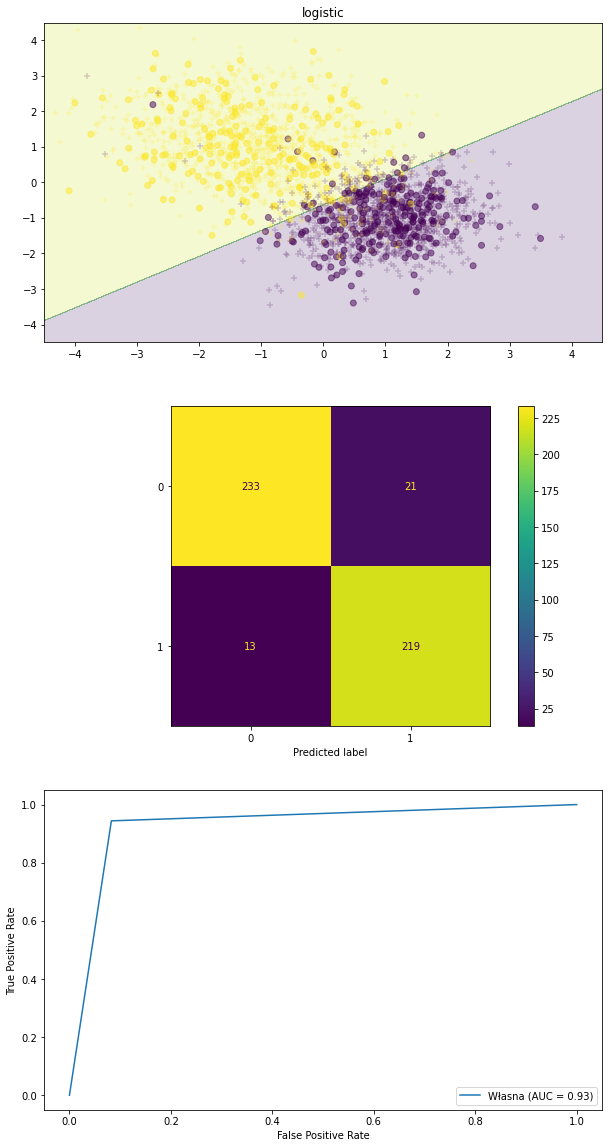

In [93]:
model = myNeuron(activation='logistic')
visualization(model ,X_train, X_test, y_train, y_test, activation='logistic')

In [81]:
lst = ['heaviside', 'sin', 'tanh', 'sign', 'relu', 'leakyRelu']

c:\users\weap\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in longlong_scalars


                  | heaviside  
Czułość           |      nan
Swoistość         |   1.0000
Accuracy          |   0.4774
Czas wykonania    | 4.53E-02
                  | sin  
Czułość           |   0.3091
Swoistość         |   0.8211
Accuracy          |   0.3909
Czas wykonania    | 4.41E-02
                  | tanh  
Czułość           |   0.6803
Swoistość         |   0.3159
Accuracy          |   0.7490
Czas wykonania    | 3.98E-02
                  | sign  
Czułość           |   0.7419
Swoistość         |   0.9069
Accuracy          |   0.5082
Czas wykonania    | 3.92E-02
                  | relu  
Czułość           |   0.5226
Swoistość         |   0.0000
Accuracy          |   0.5226
Czas wykonania    | 4.21E-02
                  | leakyRelu  
Czułość           |   0.5897
Swoistość         |   0.1812
Accuracy          |   0.6358
Czas wykonania    | 5.06E-02


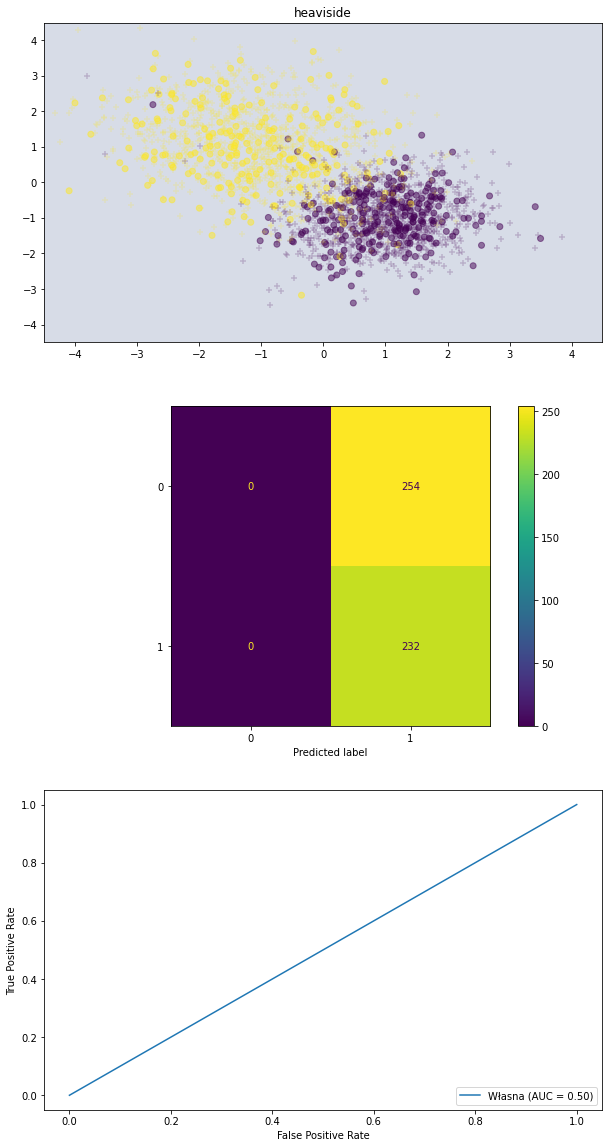

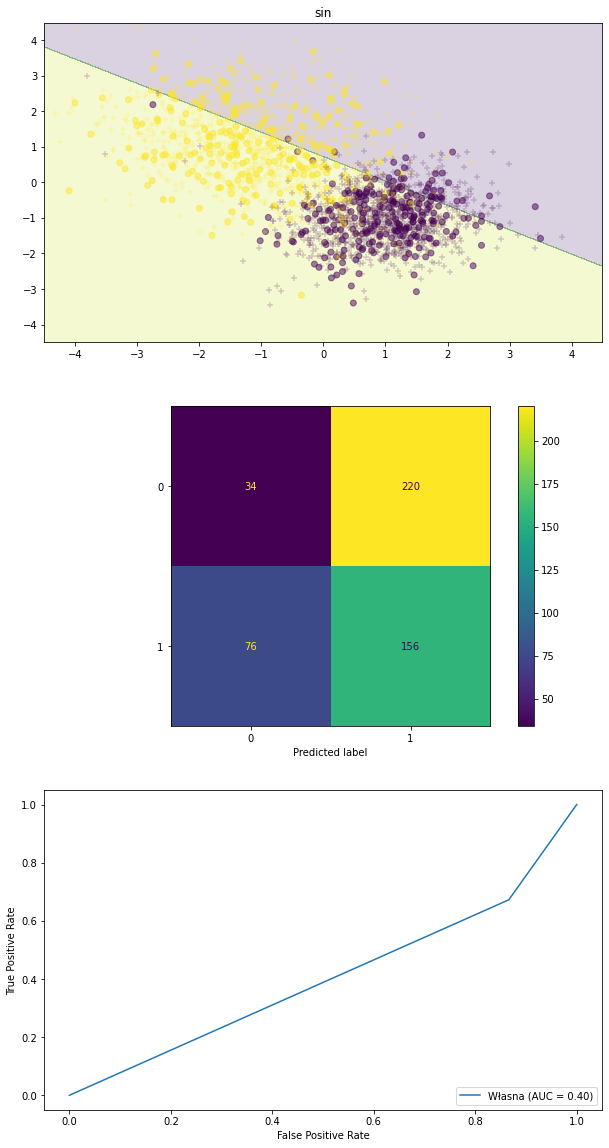

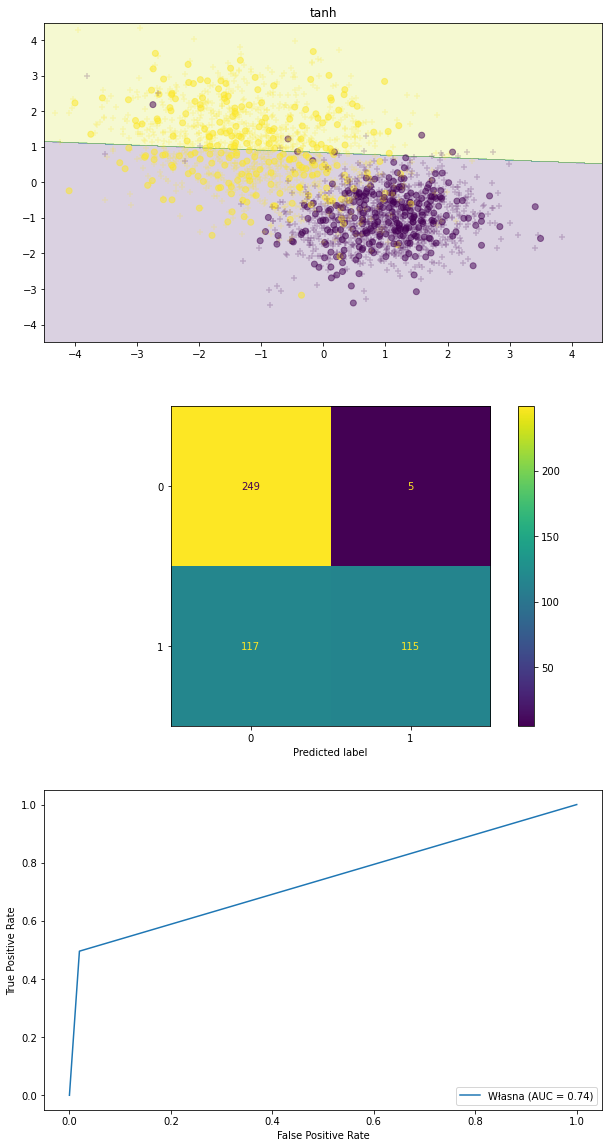

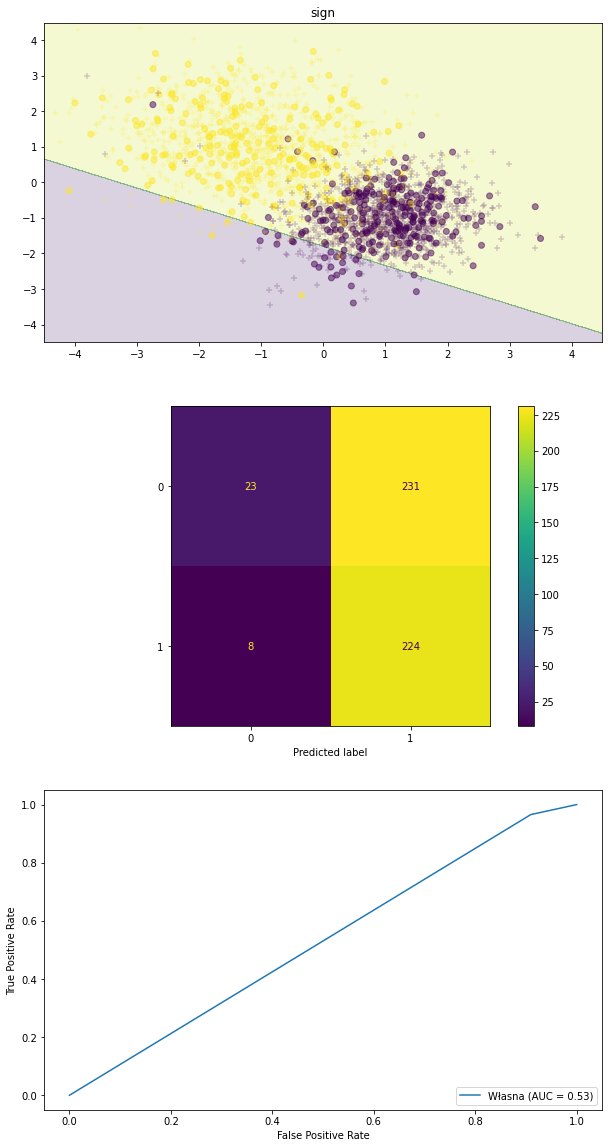

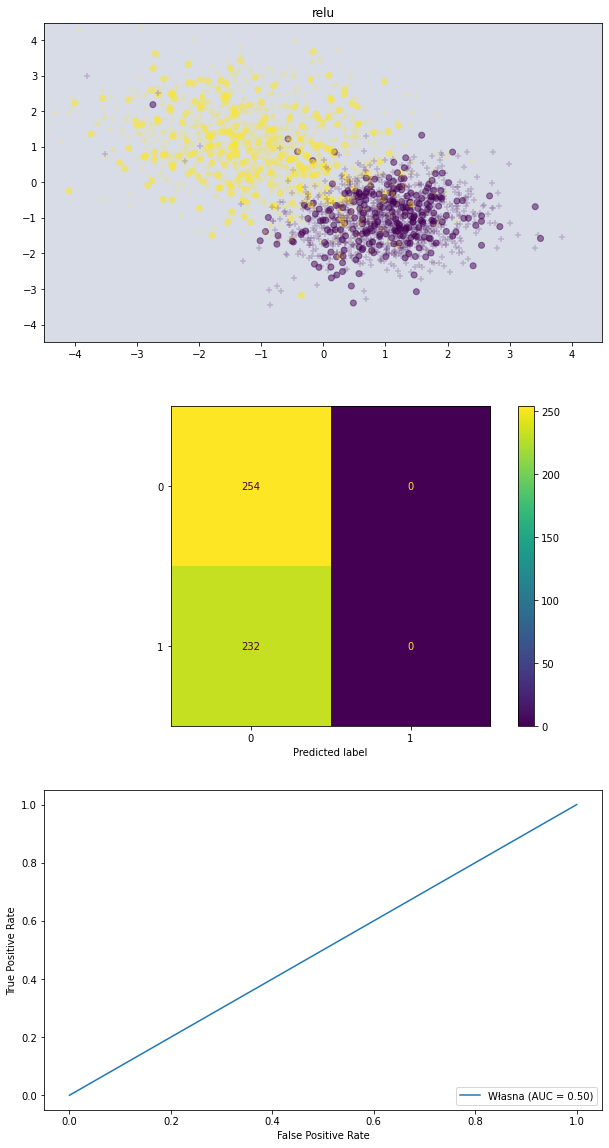

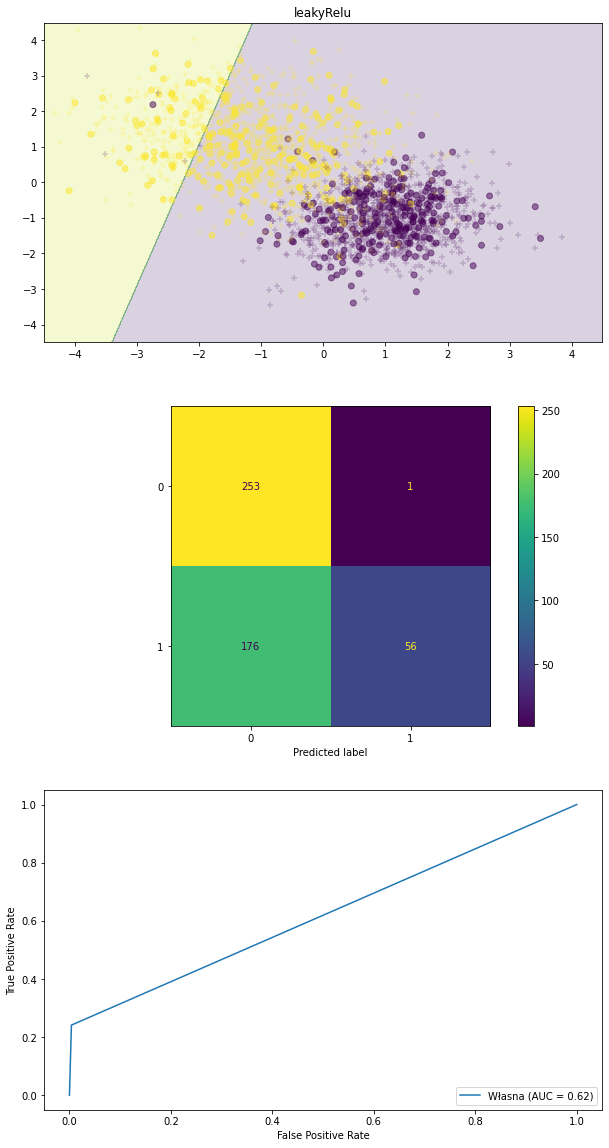

In [89]:
for activationF in lst:    
    model = myNeuron(activation = activationF)
    visualization(model ,X_train, X_test, y_train, y_test, activation=activationF)